### Manus Notebook
This files serves to understand the details of the manus codebase. The codebase is generally speaking very convoluted, so this will hopefully give some perspective on how to understand what is going on, and how to make edits.

#### Starting
The codebase is interfaced with via bash scriptseg: `train_objecct.sh`. The details for which are below.

The script is called as follows

```
source train_object.sh <subject0>

```

---

```
#!/bin/bash

SUBJECT=$1

DATA_DIR="MANUS_data"
EXP_DIR="outputs/object"
ROOT_DIR="${DATA_DIR}/${SUBJECT}"
CALIB_DIR="${ROOT_DIR}/calib.object"

HYDRA_FULL_ERROR=1




## For all the objects we want to train
OBJS=("books1")
for OBJ_NAME in "${OBJS[@]}"
do
  echo "Training $OBJ_NAME"
  OBJ_DIR="${ROOT_DIR}/objects/${OBJ_NAME}"
  EXP_OBJ_DIR="${EXP_DIR}/${SUBJECT}/${OBJ_NAME}/"

  python main.py --config-name OBJ_GAUSSIAN \
      output_dir=$EXP_OBJ_DIR \
      trainer.loggers='[csv]' \
      trainer.mode='train' \
      trainer.project='object' \
      trainer.exp_name=$OBJ_NAME \
      trainer.gpus=[0] \
      trainer.num_workers=4 \
      train_dataset.opts.split_ratio=0.98 \
      trainer.pl_vars.accumulate_grad_batches=1 \
      trainer.pl_vars.max_steps=10000 \
      train_dataset.opts.subject=$SUBJECT \
      train_dataset.opts.root_dir=$OBJ_DIR \
      train_dataset.opts.params_dir=$CALIB_DIR \
      model.opts.opacity_reset_interval=500 \
      model.opts.densification_interval=100 \
      model.opts.percent_dense=0.00001 \
      model.opts.densify_grad_threshold=0.00003 \
      model.opts.remove_outliers_step=150000 \
      model.opts.isotropic_scaling=false \
      model.opts.sample_size=300000

done
```

---

The most interesting section is the call to main.py --config name OBJ_GAUSSIAN ...

The codebase uses Hydra to manage the differing hyperparamters. The commandline interface (above) allows for default config settings to be called (OBJ_GAUSSIAN.yaml) and then overwritten with custom values (commandline arguments eg output_dir=$EXP_OBJ_DIR).

The default configs are:


        defaults:
          - trainer: trainer
          - datasets/train@train_dataset: brics_static
          - datasets/test@test_dataset: test_static
          - model: object_model
          - _self_

        ## Directory where checkpoints and output would be saved
        output_dir: "outputs/${trainer.project}/${train_dataset.opts.subject}/${trainer.exp_name}"
        hydra:
          run:
            dir: ${output_dir}

        module:
          _target_: src.modules.object.TrainingModule
          opts: ${opts}
          mode: ${trainer.mode}

        checkpoint:

        opts:
          losses: ['rgb_loss', 'ssim_loss', 'isotropic_reg']
          loss_weight: [0.8, 0.2, 0.1]
          model: ${model}
          train_dataset: ${train_dataset}
          test_dataset: ${test_dataset}
          trainer: ${trainer}
          output_dir: ${output_dir}

  



Of note is `module: __target__: src.modules.object.TrainingModule`. This is what defines what we would like to train. If we dive into `main.py` and take a look at `train()`, we can see

In [ ]:
train(config, mode=config.trainer.mode, ckpt_dir=ckpt_dir)

def train(config, mode, ckpt_dir):
    cprint("Running Train","green")
    cprint(f"Train Mode: {mode}",'magenta')
    if mode != 'test':
        cprint("Mode is NOT test",'red')
        callbacks = [
            ModelCheckpoint(
                # monitor="loss",
                dirpath=ckpt_dir,
                filename="{epoch:03d}-{step}-{loss:.6f}",
                save_top_k=-1,
                mode="min",
                every_n_epochs=1,
                verbose=True
            ),
            LearningRateMonitor(logging_interval='step'),
        ]

        loggers = []
        if mode != 'test':
            if 'csv' in config.trainer.loggers:
                loggers.extend([CSVLogger('.', name='logs', version='csv_logs')])
    else:
        callbacks = []
        loggers = []

    if mode == 'debug':
        trainer = pl.Trainer(fast_dev_run=True)
    else:
        cprint("Running pure train mode without debug or test","blue")
        ## DDP Fails for multiple models and optimizers
        # strategy = 'ddp'
        ## DDP_parameter_false works for multiple models and optimizers but slow
        # strategy = 'ddp_find_unused_parameters_false'
        trainer = pl.Trainer(
            devices=config.trainer.gpus,
            accelerator='gpu',
            callbacks=callbacks,
            logger=loggers,
            **config.trainer.pl_vars
        )

    cprint(f"Config Checkpoint is: {config.checkpoint}", "magenta")
    if config.checkpoint is not None:
        num_gaussians = get_num_gaussians_from_checkpoint(config.checkpoint)
        config.model.opts.num_gaussians = num_gaussians
        module = hydra.utils.instantiate(config.module, _recursive_=False)
        module = module.load_from_checkpoint(checkpoint_path=config.checkpoint, opts=config.opts,
                                             mode=config.trainer.mode)
    else:
        module = hydra.utils.instantiate(config.module, _recursive_=False)

    if config.trainer.torch_compile_mode is not None:
        module = torch.compile(module, mode=config.trainer.torch_compile_mode)

    if mode == 'test':
        trainer.test(module)
    else:
        trainer.fit(module)


As an example:

In [8]:
import hydra

@hydra.main(config_path="./config", config_name="OBJ_GAUSSIAN", version_base='1.1')
def main(config):
    print(config)

returns:


In [10]:
{
  'trainer': {
    'output_dir': None,
    'seed': 42,
    'gpus': [0],
    'num_workers': 4, 
    'batch_size': 1, 
    'exp_name': 'books1', 
    'project': 'object', 
    'mode': 'train', 
    'log_losses': True, 
    'loggers': ['csv'], 
    'torch_compile_mode': None,
    'accum_iter': 1,
    'pl_vars': {
      'max_steps': 10000, 
      'log_every_n_steps': 5,
      'num_sanity_val_steps': 0, 
      'limit_train_batches': 1.0, 
      'limit_val_batches': 1.0,
      'enable_progress_bar': True, 
      'precision': 32, 
      'accumulate_grad_batches': 1
    }
  }, 
  'train_dataset': {
    '_target_': 'src.datasets.brics_static.Dataset', 
    'opts': {
      'subject': 'books1', 
      'root_dir': 'MANUS_data/books1/objects/books1', 
      'params_dir': 'MANUS_data/books1/calib.object', 
      'width': 1280,
      'height': 720, 
      'resize_factor': 1.0, 
      'bg_color': 'white', 
      'near': 0.01,
      'far': 100, 
      'split_ratio': 0.98
    }
  },
  'test_dataset': {
    '_target_': 'src.datasets.brics_static.TestDataset',
    'opts': {
      'resize_factor': 1.0,
      'color_bkgd_aug': 'white', 
      'cam_path': './data/camera_paths/real.pkl', 
      'frame_sample_rate': 4,
      'test_on_train_dataset': False,
      'worst_cases': False, 
      'test_on_canonical_pose': False
      }
    },
  'model': {
    'opts': {
      'sh_degree': 3, 
      'num_gaussians': 100000,
      'sample_size': 300000, 
      'position_lr_init': 0.0016, 
      'position_lr_final': 1.6e-06,
      'position_lr_delay_mult': 0.01, 
      'position_lr_max_steps': 30000,
      'feature_lr': 0.0025, 
      'opacity_lr': 0.05, 
      'scaling_lr': 0.005, 
      'rotation_lr': 0.001, 
      'skinning_lr': 0.001, 
      'percent_dense': 1e-05, 
      'lambda_dssim': 0.2,
      'densification_interval': 100,
      'opacity_reset_interval': 500, 
      'densify': True, 
      'densify_from_step': 100, 
      'densify_until_step': 50000,
      'densify_grad_threshold': 3e-05,
      'start_lpips_iter': 1000, 
      'min_opacity_threshold': 0.005, 
      'size_threshold': 20, 
      'remove_outliers_step': 150000, 
      'isotropic_scaling': False, 
      'remove_seg_start': 0, 
      'remove_seg_end': 1000, 
      'condition_number': 0.4
      },
    '_target_': 'src.models.gaussian.GaussianModel'
    },
  'output_dir': 'outputs/object/books1/books1/', 
  'module': {
    '_target_': 'src.modules.object.TrainingModule',
    'opts': '${opts}', # train
    'mode': '${trainer.mode}' # see below
    }, 
  'opts': {
    'losses': ['rgb_loss', 'ssim_loss', 'isotropic_reg'], 
    'loss_weight': [0.8, 0.2, 0.1],
    'model': '${model}', 
    'train_dataset': '${train_dataset}',
    'test_dataset': '${test_dataset}', 
    'trainer': '${trainer}', 
    'output_dir': '${output_dir}'
    }
  }


{'trainer': {'output_dir': None,
  'seed': 42,
  'gpus': [0],
  'num_workers': 4,
  'batch_size': 1,
  'exp_name': 'books1',
  'project': 'object',
  'mode': 'train',
  'log_losses': True,
  'loggers': ['csv'],
  'torch_compile_mode': None,
  'accum_iter': 1,
  'pl_vars': {'max_steps': 10000,
   'log_every_n_steps': 5,
   'num_sanity_val_steps': 0,
   'limit_train_batches': 1.0,
   'limit_val_batches': 1.0,
   'enable_progress_bar': True,
   'precision': 32,
   'accumulate_grad_batches': 1}},
 'train_dataset': {'_target_': 'src.datasets.brics_static.Dataset',
  'opts': {'subject': 'books1',
   'root_dir': 'MANUS_data/books1/objects/books1',
   'params_dir': 'MANUS_data/books1/calib.object',
   'width': 1280,
   'height': 720,
   'resize_factor': 1.0,
   'bg_color': 'white',
   'near': 0.01,
   'far': 100,
   'split_ratio': 0.98}},
 'test_dataset': {'_target_': 'src.datasets.brics_static.TestDataset',
  'opts': {'resize_factor': 1.0,
   'color_bkgd_aug': 'white',
   'cam_path': './data/

The first issue I am facing is with a supposed folder being empty:

We cann our traindataset using the class `src.datasets.brics_static.Dataset`. This looks in the MANUS_data/books1/objects/books1 directory. The error says this is empty...

In [11]:
import cv2
import joblib
from src.utils.extra import *
from src.utils import params as param_utils
from src.utils.cam_utils import get_opengl_camera_attributes, get_scene_extent


class Dataset(torch.utils.data.Dataset):
    def __init__(self, opts, split='train'):
        self.width = opts.width
        self.height = opts.height
        self.resize_factor = opts.resize_factor
        self.instance_dir = opts.root_dir
        self.split = split
        self.bg_color = opts.bg_color

        if not os.path.exists(self.instance_dir):
            raise ValueError(f"Data directory {self.instance_dir} is empty")

        image_dir = os.path.join(self.instance_dir, "images", "refined_seg")

        if not os.path.exists(image_dir):
            raise ValueError(f"Image directory {image_dir} does not exist")

        # self.cam_file = os.path.join(self.instance_dir, '../..', 'calib', 'optim_params.txt')
        self.cam_file = os.path.join(opts.params_dir, 'optim_params.txt')
        if not os.path.exists(self.cam_file):
            raise ValueError("Camera file does not exist")

        cameras = param_utils.read_params(self.cam_file)

        # Remove the lower hemisphere views
        skip_images = [
            "brics-sbc-003_cam0",
            "brics-sbc-003_cam1",
            "brics-sbc-004_cam1",
            "brics-sbc-008_cam0",
            "brics-sbc-008_cam1",
            "brics-sbc-009_cam0",
            "brics-sbc-013_cam0",
            "brics-sbc-013_cam1",
            "brics-sbc-014_cam0",
            "brics-sbc-018_cam0",
            "brics-sbc-018_cam1",
            "brics-sbc-019_cam0",
            # "brics-sbc-027_cam0",
            # "brics-sbc-027_cam1",
            # "brics-sbc-028_cam0",
            # "brics-sbc-029_cam0",
            # "brics-sbc-029_cam1",
            # "brics-sbc-030_cam0",
            # "brics-sbc-030_cam1",
        ]

        cameras = [cam for cam in cameras if cam["cam_name"] not in skip_images]
        # cameras = np.random.choice(cameras, 9)

        if opts.split_ratio < 0.0:
            pass
        else:
            if self.split == 'train':
                # cameras = cameras[:int(opts.split_ratio * len(cameras))]
                cameras = cameras[2:]
            else:
                cameras = cameras[:2]
                # cameras = cameras[int(opts.split_ratio * len(cameras)):]



        self.images = []
        self.masks = []
        d_dict = defaultdict(list)
        self.cam2idx = {}

        for idx, cam in enumerate(cameras):
            extr = param_utils.get_extr(cam)
            K, dist = param_utils.get_intr(cam)
            cam_name = cam["cam_name"]

            img_path = os.path.join(image_dir, cam_name, '*')
            img_path = glob.glob(img_path)[0]

            self.cam2idx[cam_name] = idx

            image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            new_K, roi = param_utils.get_undistort_params(K, dist, (self.width, self.height))
            image = param_utils.undistort_image(K, new_K, dist, image)
            new_K = new_K.astype(np.float32)
            extr = extr.astype(np.float32)

            attr_dict = get_opengl_camera_attributes(new_K, extr, self.width, self.height,
                                                     resize_factor=self.resize_factor)
            for k, v in attr_dict.items():
                d_dict[k].append(v)
            d_dict['cam_name'].append(cam_name)

            if image.shape[-1] == 4:
                b, g, r, alpha = cv2.split(image)
            else:
                b, g, r = cv2.split(image)

            rgb = np.stack([r, g, b], axis=-1)
            alpha = alpha[..., np.newaxis] / 255.0
            mask = alpha

            rgb = rgb / 255.0
            color_bkgd = self.get_bg_color()
            rgb = rgb * alpha + color_bkgd * (1.0 - alpha)
            self.images.append(rgb)
            self.masks.append(mask)

        for k, v in d_dict.items():
            d_dict[k] = np.stack(v, axis=0)

        self.all_cameras = Cameras(**d_dict)
        self.extent = get_scene_extent(self.all_cameras.camera_center)
        dump_points(self.all_cameras.camera_center, f'./cam_centers_{self.split}.ply')
        self.n_images = len(self.images)
        self.all_cameras = to_tensor(self.all_cameras)

    def get_bg_color(self):
        if self.bg_color == "random":
            color_bkgd = np.random.rand(3).astype(np.float32)
        elif self.bg_color == "white":
            color_bkgd = np.ones(3).astype(np.float32)
        elif self.bg_color == "black":
            color_bkgd = np.zeros(3).astype(np.float32)
        return color_bkgd

    def sample_gaussians(self, sample_size, sample_mesh=False):
        mesh_dir = os.path.join(self.instance_dir, 'mesh', 'ngp_mesh')
        mesh_path = glob.glob(os.path.join(mesh_dir, '*.ply'))[0]
        mesh = trimesh.load(mesh_path, process=False, maintain_order=True)
        points = mesh.sample(sample_size)

        if not sample_mesh:
            rand_ind = np.random.randint(sample_size, size=sample_size)
            grid_points = create_voxel_grid([-1, 1], 256)
            np.random.shuffle(grid_points)
            grid_points = grid_points[rand_ind]
            mean = points.mean(axis=0)
            scale = np.max(np.max(points, axis=0) - np.min(points, axis=0)) / 2
            points = grid_points * scale + mean
        else:
            noise = np.random.normal(0, 0.03, points.shape)
            points = points + noise
        points_colors = torch.rand(points.shape)

        dump_points(points, './init_gaussians.ply', points_colors)
        return points, points_colors

    def get_scene_extent(self, cam_centers):
        ## Used in densify_and_prune
        avg_cam_center = np.mean(cam_centers, axis=1, keepdims=True)
        center = avg_cam_center
        dist = np.linalg.norm(cam_centers - center, axis=0, keepdims=True)
        diagonal = np.max(dist)
        radius = diagonal * 1.1
        return radius

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        sampling_idx = idx
        rgb = self.images[sampling_idx]
        mask = self.masks[sampling_idx]
        camera = self.all_cameras[sampling_idx]

        data = {
            "rgb": torch.from_numpy(rgb).float(),
            "mask": torch.from_numpy(mask).float(),
            "camera": camera,
            "scaling_modifier": 1.0,
            "bg_color": to_tensor(self.get_bg_color())
        }
        return data

    def collate_fn(self, batch_list):
        # get list of dictionaries and returns input, ground_true as dictionary for all batch instances
        batch_list = zip(*batch_list)

        all_parsed = []
        for entry in batch_list:
            if type(entry[0]) is dict:
                # make them all into a new dict
                ret = {}
                for k in entry[0].keys():
                    ret[k] = torch.stack([obj[k] for obj in entry])
                all_parsed.append(ret)
            else:
                all_parsed.append(torch.LongTensor(entry))

        return tuple(all_parsed)

    def get_scale_mat(self):
        return np.load(self.cam_file)["scale_mat_0"]


class TestDataset(torch.utils.data.Dataset):
    def __init__(self, opts, split="test"):
        super().__init__()
        self.resize_factor = opts.resize_factor
        self.bg_color = opts.color_bkgd_aug
        self.frame_sample_rate = opts.frame_sample_rate
        self.width = 1280
        self.height = 720

        self.cam_path = os.path.join(
            os.path.dirname(os.path.abspath(__file__)),
            "..",
            "..",
            opts.cam_path
        )

        cam_data = joblib.load(self.cam_path)
        Ks = cam_data["intrs"]
        extrins = cam_data["extrs"]
        self.n_frames = len(extrins[::self.frame_sample_rate])

        d_dict = defaultdict(list)

        for i in range(self.n_frames):
            fx, fy, cx, cy = Ks[i]
            K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
            RT = extrins[i]
            RT = np.vstack((RT, np.array([0, 0, 0, 1])))

            attr_dict = get_opengl_camera_attributes(K, RT[:3, :4], self.width, self.height,
                                                     resize_factor=self.resize_factor)

            for k, v in attr_dict.items():
                d_dict[k].append(v)
            d_dict['cam_name'].append(str(i))

        for k, v in d_dict.items():
            d_dict[k] = np.stack(v, axis=0)

        self.all_cameras = Cameras(**d_dict)

    def __getitem__(self, index):
        data = self.fetch_data(index)
        return data

    def fetch_data(self, index):
        camera = self.all_cameras[index]
        camera = to_tensor(camera)
        data_dict = {
            "idx": index,
            "camera": camera,
            "scaling_modifier": 1.0,
            "bg_color": torch.tensor([1.0, 1.0, 1.0]) if self.bg_color == "white" else torch.tensor([0.0, 0.0, 0.0])
        }
        return data_dict

    def __len__(self):
        return self.n_frames



Class `Dataset` takes in the following arguments:

```def __init__(self, opts, split='train'):```

Lets insantiate this object to see what happens...

In [23]:
from omegaconf import OmegaConf

opts = OmegaConf.create({
      'subject': 'books1', 
      'root_dir': 'MANUS_data/books1/objects/books1', 
      'params_dir': 'MANUS_data/books1/calib.object', 
      'width': 1280,
      'height': 720, 
      'resize_factor': 1.0, 
      'bg_color': 'white', 
      'near': 0.01,
      'far': 100, 
      'split_ratio': 0.98
    })

Dataset(opts=opts)

ValueError: Camera file does not exist

In [13]:
opts.width

AttributeError: 'dict' object has no attribute 'width'

In [15]:
myDict = {"test":5}

In [20]:
from omegaconf import OmegaConf
OmegaConf.create(myDict)

{'test': 5}

In [2]:
import torch 
import numpy as np
def strip_lowerdiag(L):
    uncertainty = torch.zeros((L.shape[0], 6), dtype=torch.float, device="cuda")

    uncertainty[:, 0] = L[:, 0, 0]
    uncertainty[:, 1] = L[:, 0, 1]
    uncertainty[:, 2] = L[:, 0, 2]
    uncertainty[:, 3] = L[:, 1, 1]
    uncertainty[:, 4] = L[:, 1, 2]
    uncertainty[:, 5] = L[:, 2, 2]
    return uncertainty

In [11]:
A = torch.Tensor([[[1,2,3],[1,2,3],[1,2,3]],
              [[1,2,3],[1,2,3],[1,2,3]],
              [[1,2,3],[1,2,3],[1,2,3]]])

#A = torch.Tensor([[1,2,3],[1,2,3],[1,2,3]])

strip_lowerdiag(A)

tensor([[1., 2., 3., 2., 3., 3.],
        [1., 2., 3., 2., 3., 3.],
        [1., 2., 3., 2., 3., 3.]], device='cuda:0')

In [12]:
A

tensor([[[1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.]],

        [[1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.]],

        [[1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.]]])

In [13]:
import taichi as ti

[Taichi] version 1.7.1, llvm 15.0.4, commit 0f143b2f, linux, python 3.10.12


[I 06/13/24 15:41:49.671 309173] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [19]:

ti_pt1 = ti.ndarray(shape=(pt1.shape[0], 3), dtype=ti.f32)

NameError: name 'pt1' is not defined

In [127]:
import matplotlib.pyplot as plt

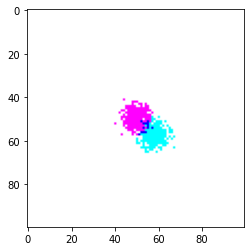

In [175]:
num_points = 500
range_min = 0
range_max = 25
grid_max = 100

grid = np.full((grid_max,grid_max,3),255)
hand = torch.normal(58,3, size=(num_points, 3)).to(torch.int32)
obj = torch.normal(50,3, size=(num_points, 3)).to(torch.int32)

def fill_grid(points, channel = 0):
    for point in points:
        try:
            grid[point[0], point[1],channel] = 0
        except:
            pass
        
fill_grid(hand[:,0:2],[0])
fill_grid(obj[:,0:2],[1])
plt.imshow(grid);



def calculate_distances(
        pt1,
        pt2,
        ti_contact_map,
        ti_contact_indices,
    ):
    print(f"Pt1 shape: {pt1.shape}")
    print(f"Pt2 shape: {pt2.shape}")
    # For each gaussian in part 1
    for i in range(pt1.shape[0]):
        min_dist = 1e9 # Contact threshold
        # For each gaussian in part 2
        for j in range(pt2.shape[0]):
            dist = 0.0 # init distance
            # for each dimension
            for k in range(3):
                dist += (pt1[i, k] - pt2[j, k]) ** 2 # distance^2 = sum[(a-b)^2]
            dist = torch.sqrt(dist) # get actual distance by taking sqroot
            # if the distance is smaller than threshold (this counts as contact)
            if dist < min_dist:
                min_dist = dist # Update threshold (why??)
                ti_contact_indices[i] = j
            ti_contact_map[i] = min_dist
    return ti_contact_map, ti_contact_indices
            
            
pt1 = hand
pt2 = obj

ti_contact_map = torch.empty(size=(pt1.shape[0],))
ti_contact_indices = torch.empty(size=(pt1.shape[0],))



In [176]:
contact_map, indices = calculate_distances(hand,obj,ti_contact_map,ti_contact_indices)

Pt1 shape: torch.Size([500, 3])
Pt2 shape: torch.Size([500, 3])


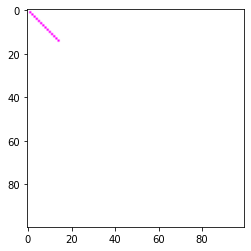

In [156]:
cmap_int = contact_map.to(torch.int32)
(255- contact_map).to(torch.int32)
grid_max = 100

grid = np.full((grid_max,grid_max,3),255)

for point in cmap_int:
    grid
plt.imshow(grid)

In [178]:
# distance to nearest point
contact_map 

tensor([ 8.0623,  7.5498,  1.0000, 11.0000,  7.0711,  8.3666,  9.9499,  8.3066,
         7.8740,  6.4031,  8.7750,  5.0990,  9.8995,  2.2361,  7.4833,  7.4833,
         6.0000,  8.3066,  3.7417,  8.6023,  6.1644,  6.4807,  6.3246,  6.7082,
         8.6023, 12.3288,  6.1644,  7.2801,  8.6023,  5.0990,  8.7750,  7.3485,
         9.8995, 10.0499,  5.6569,  8.0623,  7.8740,  6.6332,  6.4031,  6.7082,
         7.2801,  7.4833, 10.4881,  4.8990, 11.1803,  8.3666,  8.3666,  3.7417,
         8.6023,  8.4853,  6.0828,  5.4772,  9.0000,  5.0990,  8.3066, 10.7703,
        11.1803,  5.4772,  4.8990, 10.2470,  7.0000,  7.8102, 11.2250, 11.1803,
         6.7082,  4.6904,  8.3666,  5.8310,  8.6023,  9.2736,  6.1644,  8.6603,
         7.0711,  4.6904,  7.4833,  8.8318,  4.2426, 13.4164,  8.3666,  9.0554,
         6.1644, 10.2956,  6.1644, 11.1803,  9.8995,  7.6811,  7.0711,  6.7082,
         7.5498,  4.5826,  8.1240,  7.5498,  5.3852,  2.4495,  5.4772,  6.1644,
         5.8310,  8.6023,  4.1231,  4.69

In [179]:
indices

tensor([110., 256., 396., 402., 129., 256., 402., 396., 256., 256., 402., 402.,
        396., 402., 256., 256., 256., 402., 402., 402., 110., 256., 256., 256.,
        402., 244., 402., 402., 402., 256., 256., 256., 402., 256.,   1., 256.,
        256., 402., 402., 110., 256., 256., 256., 256., 256., 110., 402., 129.,
        402., 256., 256., 256., 402., 256., 129., 396., 402., 256., 129., 256.,
        402., 256., 396., 402., 402., 402., 256., 402., 396., 110., 256., 402.,
        256., 402., 396., 110., 256., 396., 256., 129., 402., 256., 402., 256.,
        402., 256., 256., 402., 256., 256., 256., 256., 402., 256., 402., 396.,
          1., 110., 256., 256., 129., 110., 402., 110., 402., 256., 256., 256.,
        256., 110., 256., 189., 256., 110., 256., 256., 256., 110., 402., 402.,
        319., 402., 256., 402., 256., 256., 256.,   7., 256., 256., 256., 402.,
        256., 256., 256., 256., 396., 110., 256., 256., 256., 256., 110., 256.,
        256., 256., 256., 129., 256., 25

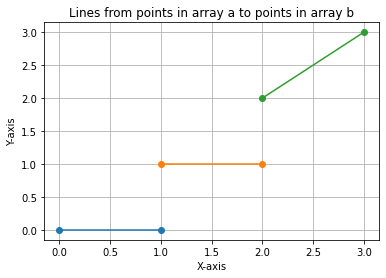

In [209]:

def plot_lines(a, b):
    """
    Plot lines connecting points from array a to array b.

    Parameters:
        a (np.ndarray): An array of shape (n, 2) representing n points with (x, y) coordinates.
        b (np.ndarray): An array of shape (n, 2) representing n points with (x, y) coordinates.
    """
    if a.shape != b.shape:
        raise ValueError("Arrays a and b must have the same shape.")
    
    # Plot each line
    for i in range(a.shape[0]):
        x_values = [a[i, 0].tolist(), b[i, 0].tolist()]
        y_values = [a[i, 1], b[i, 1]]
        plt.plot(x_values, y_values, marker='o')
    
    # Set labels and show the plot
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Lines from points in array a to points in array b')
    plt.grid(True)
    plt.show()

# Example usage
a = np.array([[0, 0], [1, 1], [2, 2]])
b = np.array([[1, 0], [2, 1], [3, 3]])

plot_lines(a, b)

In [197]:
obj[indices.to(torch.int32)]

tensor([[57, 48, 57],
        [56, 54, 53],
        [51, 56, 54],
        ...,
        [56, 54, 53],
        [56, 54, 53],
        [54, 57, 45]], dtype=torch.int32)

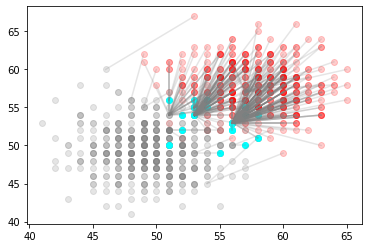

In [238]:
dim1 = 0
dim2 = 2
plt.scatter(hand[:,dim1],hand[:,dim2], color="red", alpha=0.2)
plt.scatter(obj[:,dim1],obj[:,dim2], color="grey", alpha=0.2)
x_values = [hand[:,dim1].tolist(), obj[indices.to(torch.int32),dim1].tolist()]
y_values = [hand[:,dim2].tolist(), obj[indices.to(torch.int32),dim2].tolist()]

plt.plot(x_values, y_values, alpha=0.2, color="grey");

threshold = 3
contacts = contact_map < threshold
plt.scatter(hand[contacts,dim1], hand[contacts,dim2], color="cyan")

#plt.ylim([20,100])
#plt.xlim([20,100])